# Posterior calculations for d

Here we use the data from the cluster to fit a prior GMM distribution function to the perpendicular distance d. Then we will define a likelihood on the data and derive a posterior distance function using the high latitude sample.

# Prior

Many of my algos have been written for torch but its fairly simple to swap to numpy.

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import torch
os.chdir('../')
from star_sample import Isochrones,StarSample
from Distributions.xdeconv import XDGMM
os.chdir('Data')
prior_df=pd.read_csv('prior_data')
pkl_file = open('isochrones_high_lat.pkl', 'rb')

Isochrone_hl = pickle.load(pkl_file)

pkl_file = open('high_lat_values.pkl', 'rb')

High_Latitude_sample = pickle.load(pkl_file)
os.chdir('../')

# Prior

We are going to fit an XDGMM to the perpendicular distance to get a prior on $d$.

In [2]:
d_obs=prior_df['perp'].copy().to_numpy()
d_obs_err=np.sqrt(prior_df['perp_err'].copy().to_numpy())

We use 5 components. There is an official test but I just did this by eye.

In [3]:
gmm=XDGMM(5).fit(d_obs.reshape(len(d_obs),1),Xerr=(d_obs_err**2).reshape(len(d_obs_err),1,1),R=np.array([1.0]).reshape(1,1,1))


### Comparison of the GMM with true data

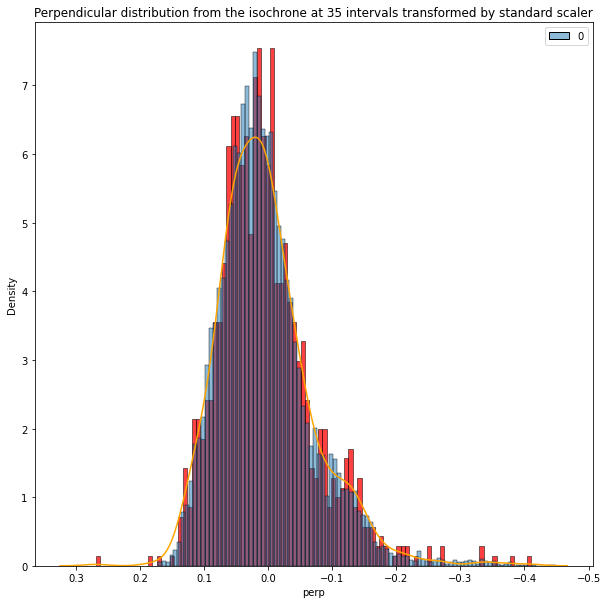

In [4]:
sam=gmm.sample(10000)
f, ax = plt.subplots(1, 1, figsize=(10,10))
plt.title('Perpendicular distribution from the isochrone at 35 intervals transformed by standard scaler')
sn.histplot(prior_df['perp'],ax=ax,kde=False,legend=False,bins=100,stat='density',color='r')
sn.kdeplot(prior_df['perp'],ax=ax,color='orange')
sn.histplot(sam,ax=ax,bins=100,stat='density',color='b')
#sn.kdeplot(sam,ax=ax,color='black')
ax.invert_xaxis()
plt.show()

### Retrieve the Prior on $d$.
This is only the prior on the observed, we need to derive it in general.

In [5]:
mixing_coeff=gmm.alpha
means=gmm.mu
variance=gmm.V

# Posterior

We will begin only with Gaia magnitudes for now.

Assume: distance is known perfectly from the Bailer Jones. This later will have to be included in the model and we have our own prior on parallax.

In [6]:
High_Latitude_sample.data['G']=High_Latitude_sample.data['phot_g_mean_mag']-5*np.log10(High_Latitude_sample.data['r_med_geo'])+5

Make some cuts on logg and the distance.

In [7]:
High_Latitude_sample.data=High_Latitude_sample.data[High_Latitude_sample.data['logg_gspphot']>4.0].reset_index(drop=True)
High_Latitude_sample.data=High_Latitude_sample.data[High_Latitude_sample.data['logg_gspphot']<4.6].reset_index(drop=True)
High_Latitude_sample.data=High_Latitude_sample.data[High_Latitude_sample.data['r_med_geo']<1000.0].reset_index(drop=True)

### Create the dataframe by stacking the isochrones, producing isochrones which are of loggage 9.0 and FeH which has been produced from the calibration provided by Gaia and the GSP_Phot values. We concatenate them together into a datacube. This datacube is what is going to be fed into the model.

In [8]:
stacked_isochrones=Isochrone_hl.stack_isochrones()
x_values=High_Latitude_sample.to_tensor(expandsize=stacked_isochrones.shape[-2])

In [9]:
age_list=[9.0]
feh_list=High_Latitude_sample.data['mh_gspphot'].values#feh_list=[0.17 for i in range(len(x_values))]#Cluster_sample.data['mh_gspphot']
stacked_isochrones=Isochrone_hl.stack_isochrones_subsample(feh_list,age_list)

In [10]:
x_columns=High_Latitude_sample.data.columns
isoc_columns=Isochrone_hl.isochrones_list[0].columns
def column_index(name):
    if name in x_columns:
        return np.where(np.array(x_columns)==name)[0][0]
    else:
        return np.where(np.array(isoc_columns)==name)[0][0] +len(x_columns)

In [11]:
isochrone=torch.cat([x_values,stacked_isochrones],dim=-1)

In [12]:
isochrone.shape

torch.Size([19313, 96, 55])

In [13]:
isochrone=isochrone.numpy()

# NumPyro

In [14]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp

rng_key = random.PRNGKey(0)
assert numpyro.__version__.startswith("0.10.1")

In [15]:
isochrone=jnp.array(isochrone)

Move the isochrone

In [16]:
import math


In [17]:
m=math.atan(2.02)
dx=math.cos(m)
dy=math.sin(m)

upper_bound_x=isochrone[:,:,column_index('BPRP')]+dx
upper_bound_y=isochrone[:,:,column_index('Gaia_G_EDR3')]+dy

lower_bound_x=isochrone[:,:,column_index('BPRP')]-dx
lower_bound_y=isochrone[:,:,column_index('Gaia_G_EDR3')]-dy

In [18]:
xg_meas=isochrone[:,0,column_index('G')]
xc_meas=isochrone[:,0,column_index('bp_rp')]

xg_std=isochrone[:,0,column_index('phot_g_mean_mag_error')]
xc_std=isochrone[:,0,column_index('bp_rp_error')]

In [19]:
x_input=jnp.stack([xc_meas,xg_meas],axis=1)
x_err=jnp.stack([xc_std,xg_std],axis=1)

In [20]:
I_2=jnp.eye(2) 
dist_error=dist.MultivariateNormal(jnp.array([[0,0] for i in range(len(x_input))]),jnp.array([I_2 for i in range(len(x_input))]))


In [21]:
mixing_dist = mixing_dist = dist.Categorical(probs = jnp.array(mixing_coeff))
component_dists = [
    dist.Normal(loc=means[i], scale=jnp.sqrt(variance[i])) for i in range(len(means))]
# is it variance or variance squared
mixture = dist.MixtureGeneral(mixing_dist, component_dists)


In [22]:
#that will need to be reshaped
samples=mixture.sample(key=rng_key,sample_shape=(1000,))

# I'm having trouble figuring out how to evaluate the likelihood of all of the different points. However, if every point splits into two points and then I stack them with repeated values in x_err and x_g etc that could work. I would like to be able to do this but I'm running out of memory. Something could be done.

In [23]:
#var=jnp.array([jnp.diag(x_err[:,i]) for i in range (len(x_err))])


In [24]:
isochrone=isochrone[:10]

In [27]:

import math
m=math.atan(2.02)

xg_meas=isochrone[:,:,column_index('G')].reshape(isochrone.shape[0]*isochrone.shape[1])
xc_meas=isochrone[:,:,column_index('bp_rp')].reshape(isochrone.shape[0]*isochrone.shape[1])
xg_meas=jnp.concatenate([xg_meas,xg_meas])
xc_meas=jnp.concatenate([xc_meas,xc_meas])
x_input=jnp.stack([xc_meas,xg_meas],axis=1)

xg_std=isochrone[:,:,column_index('phot_g_mean_mag_error')].reshape(isochrone.shape[0]*isochrone.shape[1])
xc_std=isochrone[:,:,column_index('bp_rp_error')].reshape(isochrone.shape[0]*isochrone.shape[1])

xg_std=jnp.concatenate([xg_std,xg_std])
xc_std=jnp.concatenate([xc_std,xc_std])

x_err=jnp.stack([xc_std,xg_std],axis=1)

def model(isochrone,x_input,x_err,x_obs=None,y_obs=None):
    import math
    d=numpyro.sample("d",mixture,rng_key=rng_key).reshape(1)
    
    dx=math.cos(m)
    dy=math.sin(m)

    upper_bound_x=isochrone[:,:,column_index('BPRP')].reshape(isochrone.shape[0]*isochrone.shape[1])+d*dx
    upper_bound_y=isochrone[:,:,column_index('Gaia_G_EDR3')].reshape(isochrone.shape[0]*isochrone.shape[1])+d*dy
    lower_bound_x=isochrone[:,:,column_index('BPRP')].reshape(isochrone.shape[0]*isochrone.shape[1])-d*dx
    lower_bound_y=isochrone[:,:,column_index('Gaia_G_EDR3')].reshape(isochrone.shape[0]*isochrone.shape[1])-d*dy

    


    bound_x=jnp.concatenate([upper_bound_x,lower_bound_x]) #as twice the number of points from bounds
    bound_y=jnp.concatenate([upper_bound_y,lower_bound_y])
    bounds=jnp.stack([bound_x,bound_y],axis=1)

    with numpyro.plate('data',len(x_err)):
        numpyro.sample("obs_x",dist.MultivariateNormal(bound_x,xc_std**2),rng_key=rng_key,obs=x_obs)
        numpyro.sample("obs_y",dist.MultivariateNormal(bound_y,xg_std**2),rng_key=rng_key,obs=y_obs)
            
        


In [28]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2, num_warmup=2,num_chains=3,progress_bar=True)
mcmc.run(rng_key, isochrone, x_input,x_err, x_obs=xc_meas,y_obs=xg_meas)

posterior_samples = mcmc.get_samples()

/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_54417/2449899603.py:3: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=2, num_warmup=2,num_chains=3,progress_bar=True)


ValueError: MultivariateNormal distribution got invalid loc parameter.

# Using nearest allow it to choose the nearest one. I don't really want to do this but due to memory concerns ok

In [ ]:



import math
m=math.atan(2.02)

xg_meas=isochrone[:,0,column_index('G')]
xc_meas=isochrone[:,0,column_index('bp_rp')]
xg_meas=jnp.concatenate([xg_meas,xg_meas])
xc_meas=jnp.concatenate([xc_meas,xc_meas])
x_input=jnp.stack([xc_meas,xg_meas],axis=1)

xg_std=isochrone[:,0,column_index('phot_g_mean_mag_error')]
xc_std=isochrone[:,0,column_index('bp_rp_error')]

xg_std=jnp.concatenate([xg_std,xg_std])
xc_std=jnp.concatenate([xc_std,xc_std])

x_err=jnp.stack([xc_std,xg_std],axis=1)





def model(isochrone,x_input,x_err,x_obs=None,y_obs=None):
    import math
    d=numpyro.sample("d",mixture,rng_key=rng_key).reshape(1)
    
    dx=math.cos(m)
    dy=math.sin(m)

    upper_bound_x=isochrone[:,:,column_index('BPRP')]+d*dx
    upper_bound_y=isochrone[:,:,column_index('Gaia_G_EDR3')]+d*dy
    lower_bound_x=isochrone[:,:,column_index('BPRP')]-d*dx
    lower_bound_y=isochrone[:,:,column_index('Gaia_G_EDR3')]-d*dy

    bound_x=jnp.concatenate([upper_bound_x,lower_bound_x])
    bound_y=jnp.concatenate([upper_bound_y,lower_bound_y])

    real_x=jnp.concatenate([isochrone[:,:,column_index('bp_rp')],isochrone[:,:,column_index('bp_rp')]])
    real_y=jnp.concatenate([isochrone[:,:,column_index('G')],isochrone[:,:,column_index('G')]])

    dl=jnp.sqrt((bound_x-real_x)**2+(bound_y-real_y)**2)

    idx_l=jnp.argmin(jnp.nan_to_num(dl,nan=jnp.inf),-1)

    xg=jnp.take_along_axis(bound_y,idx_l.reshape(-1,1),1)
    xc=jnp.take_along_axis(bound_x,idx_l.reshape(-1,1),1)





    with numpyro.plate('data',len(x_err)):
        numpyro.sample("obs_x",dist.MultivariateNormal(xc,xc_std**2),rng_key=rng_key,obs=x_obs)
        numpyro.sample("obs_y",dist.MultivariateNormal(xg,xg_std**2),rng_key=rng_key,obs=y_obs)
            
        


In [ ]:
numpyro.set_host_device_count(3)

/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_54160/2449899603.py:3: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=2, num_warmup=2,num_chains=3,progress_bar=True)


In [ ]:
x_err.shape

(3708096, 2)

In [ ]:
jnp.diag(x_err)

DeviceArray([0.06460058, 0.00375002], dtype=float32)

In [ ]:




a1=-1*isochrone[:,:,column_index('slopes')]
b1=1.0
c1=isochrone[:,:,column_index('slopes')]*isochrone[:,:,column_index('BPRP')]-isochrone[:,:,column_index('Gaia_G_EDR3')]


x=(b1*c2-b2*c1).clone()/(a1*b2-a2*b1).clone()
y=(a2*c1-a1*c2).clone()/(a1*b2-a2*b1).clone()

sgn=torch.sign((y.clone()-isochrone[:,:,column_index('G')].clone())/(x.clone()-isochrone[:,:,column_index('bp_rp')].clone()))

d=torch.sqrt((x.clone()-isochrone[:,:,column_index('bp_rp')].clone())**2+(y.clone()-isochrone[:,:,column_index('G')].clone())**2)
for i in range(len(d)):
    plt.plot(d[i])
plt.title('Distance along reddening per component for each datapoint')
idx=torch.argmin(torch.abs(d/truth.reshape(d.shape)).nan_to_num(nan=torch.inf),-1)

sgn=sgn.gather(1,idx.view(-1,1))
d=d.gather(1,idx.view(-1,1))*sgn

NameError: name 'c2' is not defined